# `sklearn-mrmr` demo and comparison

This notebook demonstrates how to use `sklearn-mrmr` with `sklearn`'s pipelines for cross-validation and hyperparameter optimization. Both a classification and a regression example are provided.

**The best $k$ features is a tunable parameter!**

</br></br>

#### Table of contents

* Classification with logistic regression
    - Data
    - Pipeline without feature selection
    - Pipeline with MRMR feature selection
    - Examine results
* Regression example
    - Data
    - Pipeline without feature selection
    - Pipeline with MRMR feature selection
    - Examine results

In [21]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

sys.path.append(os.path.abspath('sklearn-mrmr'))
from mrmr import MRMRFeatureSelector


## Classification with logistic regression

### Data

This dataset concerns the manufacturing of semiconductors, and is availabe from Kaggle: https://www.kaggle.com/datasets/paresh2047/uci-semcom/.

In [22]:
df = pd.read_csv('~/Downloads/uci-secom.csv')

# Relabel target column, drop time column
df = df.replace(to_replace=[-1, 1], value=[1, 0]) \
       .drop(['Time'], axis=1)

# Eliminate columns that have >50 missing values (~10% of total sample)
# leaving about 500 columns left
df = df.loc[:, df.isnull().sum() < 50]

df.head()

,0,1,2,3,4,5,6,7,8,9,...,577,582,583,584,585,586,587,588,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,14.9509,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,10.9003,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,9.2721,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,0
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,8.5831,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,10.9698,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,1


In [23]:
y = df['Pass/Fail']
X = df.drop('Pass/Fail', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

### Pipeline without feature selection

This logistic regression uses all available features. K-nearest neighbors is chosen as an imputation strategy, and inputs are standardized.

In [24]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

basic_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(random_state=42))
])

param_grid_basic = {
    'regressor__max_iter': [500]
}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5,
                                 scoring='f1_weighted')

grid_search_basic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', KNNImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor',
                                        LogisticRegression(random_state=42))]),
             param_grid={'regressor__max_iter': [500]}, scoring='f1_weighted')

### Pipeline with MRMR feature selection

In [25]:
%%capture output

mrmr_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('selector', MRMRFeatureSelector(method='ftest')),
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(random_state=42))
])

param_grid_mrmr = {
    'selector__n_features_to_select': [10, 25, 50, 75, 100, 200, 300, 400, 500],
    'regressor__max_iter': [500]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5,
                                scoring='f1_weighted')

grid_search_mrmr.fit(X_train, y_train)

### Examine results

In [26]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 530

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv = pd.concat([cv_basic, cv_mrmr])

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.172945,0.033130,0.050107,0.007713,500,{'regressor__max_iter': 500},0.898995,0.890915,0.874754,0.887756,0.893427,0.889169,0.008093,1,basic,530
0,0.167527,0.020558,0.040363,0.005536,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.897600,0.899593,0.899593,0.906218,0.899197,0.900440,0.002981,2,mrmr,10
1,0.272066,0.024242,0.052256,0.004164,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.897600,0.899593,0.899593,0.906218,0.899197,0.900440,0.002981,2,mrmr,25
2,0.398431,0.010198,0.043667,0.009770,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.897600,0.899593,0.899593,0.906218,0.899197,0.900440,0.002981,2,mrmr,50
3,0.495872,0.054194,0.041356,0.004664,500,"{'regressor__max_iter': 500, 'selector__n_feat...",0.897600,0.899593,0.899593,0.906218,0.899197,0.900440,0.002981,2,mrmr,75


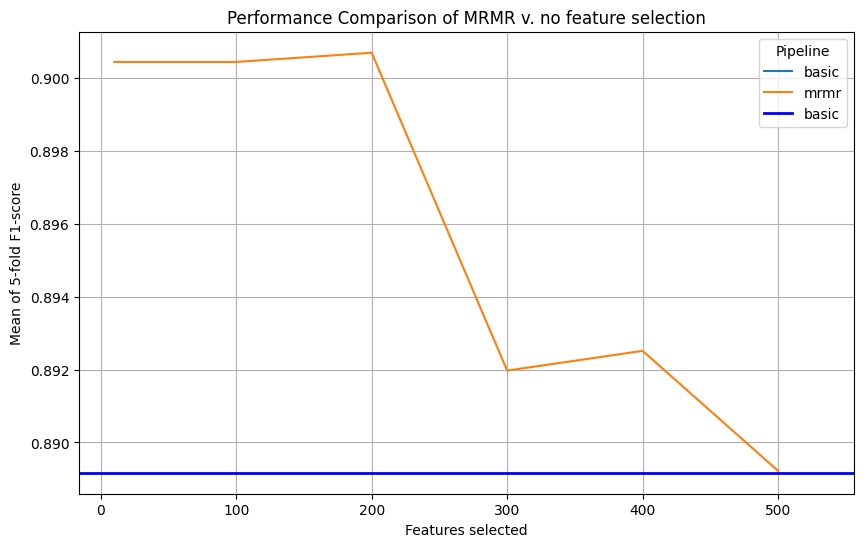

In [27]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'mean_test_score', 'std_test_score']]

basic_mean = dff.query('pipeline == "basic"')['mean_test_score'].values[0]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_mean, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Mean of 5-fold F1-score')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

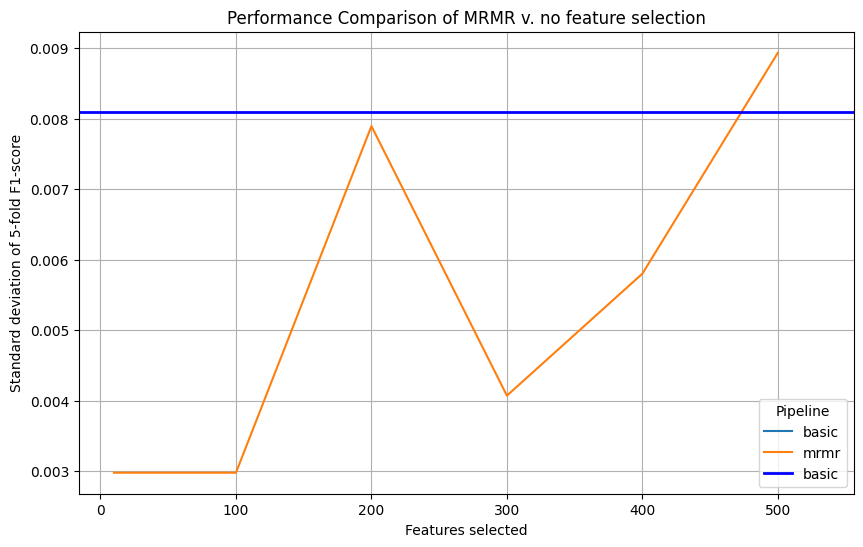

In [28]:
basic_std = dff.query('pipeline == "basic"')['std_test_score'].values[0]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='std_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_std, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Standard deviation of 5-fold F1-score')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

The plots above show that MRMR did improve the overall performance of the model, although only slightly. However, the standard deviation of the test results show a distinct benefit to using MRMR. The pipeline without feature selection has almost 4 times the standard deviation as the MRMR pipeline with 100 features.

MRMR selects 200 features as optimal. You can retrieve the index of these selected features using the `selected_freatures_` method:

In [29]:
selected_features_ix = grid_search_mrmr.best_estimator_.named_steps['selector'].selected_features_

X_train.columns[selected_features_ix]

Index(['103', '5', '13', '42', '49', '52', '69', '97', '141', '149',
       ...
       '467', '115', '416', '33', '62', '213', '211', '443', '349', '146'],
      dtype='object', length=200)

## Regression example

This is the "Community and Crime" dataset from UCI: https://archive.ics.uci.edu/dataset/183/communities+and+crime/. The dataset consists of 127  features "picked if there was any plausible connection to crime." The task is to predict violent crimes per population unit.

### Data

In [30]:
column_names = [
    'state', 'county', 'community', 'communityname', 'fold', 'population',
    'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 
    'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 
    'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 
    'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 
    'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 
    'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 
    'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 
    'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 
    'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 
    'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 
    'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 
    'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 
    'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 
    'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 
    'PctLargHouseFam', 'PctLargHouseOccup', 'PersPerOccupHous', 
    'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 
    'PctPersDenseHous', 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 
    'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded', 'PctVacMore6Mos', 
    'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 
    'OwnOccMedVal', 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 
    'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc', 'MedOwnCostPctIncNoMtg', 
    'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 
    'PctSameHouse85', 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 
    'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
    'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 
    'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
    'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 
    'PolicAveOTWorked', 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 
    'PolicOperBudg', 'LemasPctPolicOnPatr', 'LemasGangUnitDeploy', 
    'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop'
]

In [31]:
df = pd.read_csv('~/Downloads/communities/communities.data', header=None, names=column_names)

df = df.replace('?', np.NaN)

# Retain columns with no missing values
df = df.loc[:, df.isna().mean() == 0]

df.head()

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,8,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,0.17,0.34,...,0.12,0.42,0.50,0.51,0.64,0.12,0.26,0.20,0.32,0.20
1,53,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.00,0.67
2,24,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,0.04,0.39,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.00,0.43
3,34,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,0.10,0.51,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.00,0.12
4,42,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,0.05,0.38,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.00,0.03


In [32]:
y = df['ViolentCrimesPerPop']
X = df.drop(['ViolentCrimesPerPop', 'state', 'communityname', 'fold'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1804)

### Pipeline without feature selection

In [34]:
from sklearn.linear_model import LinearRegression

basic_pipeline = Pipeline(steps=[
    ('regressor', LinearRegression())
])

param_grid_basic = {}

grid_search_basic = GridSearchCV(estimator=basic_pipeline, param_grid=param_grid_basic, cv=5,
                                 scoring='neg_root_mean_squared_error')

grid_search_basic.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('regressor', LinearRegression())]),
             param_grid={}, scoring='neg_root_mean_squared_error')

### Pipeline with MRMR feature selection

In [35]:
%%capture output

mrmr_pipeline = Pipeline(steps=[
    ('selector', MRMRFeatureSelector(method='ftest')),
    ('regressor', LinearRegression())
])

param_grid_mrmr = {
    'selector__n_features_to_select': [10, 20, 30, 40, 50, 60, 70, 80, 90]
}

grid_search_mrmr = GridSearchCV(estimator=mrmr_pipeline, param_grid=param_grid_mrmr, cv=5,
                                scoring='neg_root_mean_squared_error')

grid_search_mrmr.fit(X_train, y_train)

### Examine results

In [36]:
# Assemble CV
cv_basic = pd.DataFrame(grid_search_basic.cv_results_)
cv_basic['pipeline'] = 'basic'
cv_basic['param_selector__n_features_to_select'] = 99

cv_mrmr = pd.DataFrame(grid_search_mrmr.cv_results_)
cv_mrmr['pipeline'] = 'mrmr'

cv = pd.concat([cv_basic, cv_mrmr])

cv['mean_test_score'] *= -1.0

cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,pipeline,param_selector__n_features_to_select
0,0.244931,0.047636,0.023073,0.008619,{},-0.127676,-0.126915,-0.148637,-0.151775,-0.142950,0.139590,0.010433,1,basic,99
0,0.145766,0.066894,0.000469,0.000020,{'selector__n_features_to_select': 10},-0.134673,-0.129705,-0.154335,-0.153288,-0.151855,0.144771,0.010422,9,mrmr,10
1,0.267478,0.033790,0.001649,0.002308,{'selector__n_features_to_select': 20},-0.131147,-0.127776,-0.152110,-0.153017,-0.145892,0.141988,0.010572,8,mrmr,20
2,0.278733,0.013724,0.034461,0.007264,{'selector__n_features_to_select': 30},-0.126851,-0.125252,-0.147379,-0.151705,-0.141980,0.138633,0.010737,1,mrmr,30
3,0.393360,0.117260,0.039005,0.014569,{'selector__n_features_to_select': 40},-0.126717,-0.125997,-0.146867,-0.150903,-0.143193,0.138735,0.010400,2,mrmr,40


In [37]:
dff = cv[['pipeline', 'param_selector__n_features_to_select', 'mean_test_score', 'std_test_score']]

basic_mean = dff.query('pipeline == "basic"')['mean_test_score'].values[0]

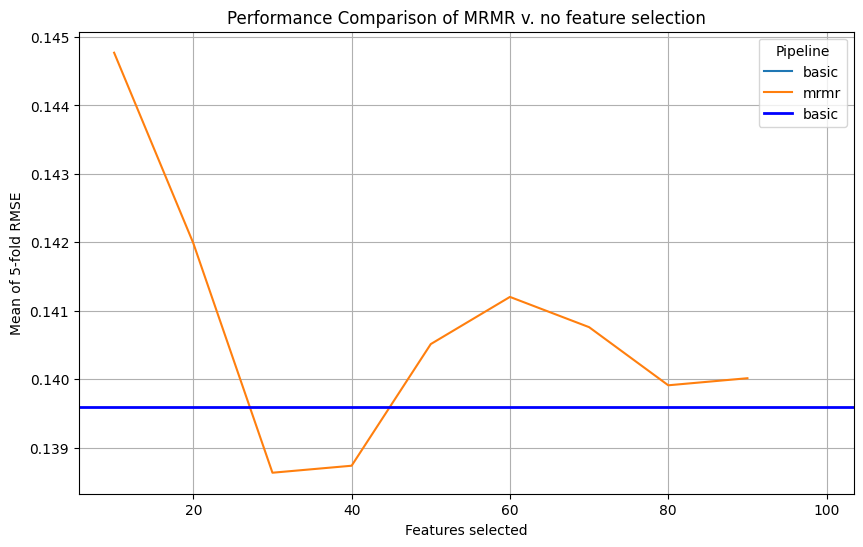

In [38]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='mean_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_mean, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Mean of 5-fold RMSE')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

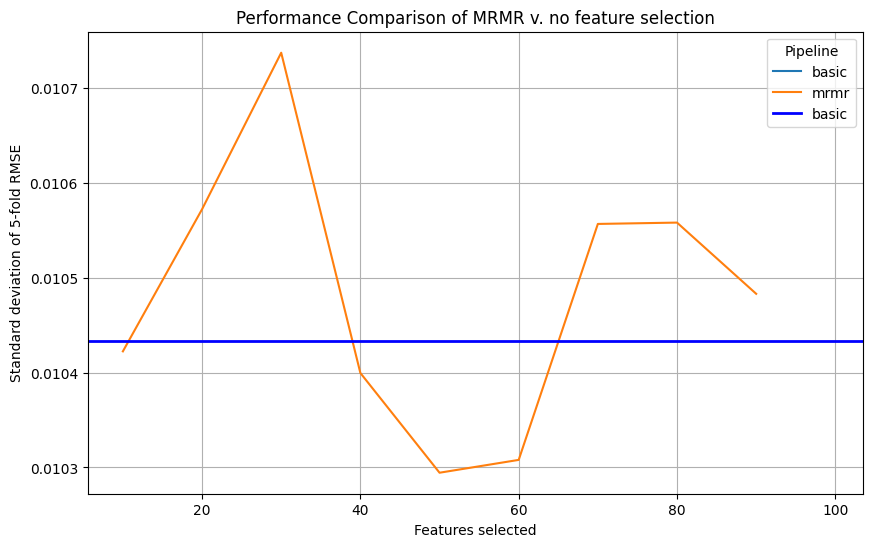

In [39]:
basic_std = dff.query('pipeline == "basic"')['std_test_score'].values[0]

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=dff, x='param_selector__n_features_to_select', y='std_test_score',
             hue='pipeline', markers=True, dashes=False)
plt.axhline(y=basic_std, color='blue', linestyle='-', linewidth=2, label='basic')

plt.xlabel('Features selected')
plt.ylabel('Standard deviation of 5-fold RMSE')
plt.title('Performance Comparison of MRMR v. no feature selection')
plt.legend(title='Pipeline')
plt.grid(True)

# Show the plot
plt.show()

Optimal $k = 30$. Selected feature names can be retrieved from the selector:

In [40]:
selected_features_ix = grid_search_mrmr.best_estimator_.named_steps['selector'].selected_features_

X_train.columns[selected_features_ix]

Index(['PctIlleg', 'PctKids2Par', 'PctFam2Par', 'racePctWhite',
       'PctYoungKids2Par', 'PctTeen2Par', 'racepctblack', 'pctWInvInc',
       'pctWPubAsst', 'FemalePctDiv', 'TotalPctDiv', 'PctPersOwnOccup',
       'MalePctDivorce', 'PctPopUnderPov', 'PctUnemployed', 'PctHousNoPhone',
       'PctVacantBoarded', 'PctNotHSGrad', 'PctHousOwnOcc', 'NumIlleg',
       'PctHousLess3BR', 'PctPersDenseHous', 'NumUnderPov', 'medFamInc',
       'HousVacant', 'medIncome', 'PctLess9thGrade', 'PctLargHouseFam',
       'population', 'PctWOFullPlumb'],
      dtype='object')

You can access the corresponding "importance" scores via the `scores_` attribute:

In [41]:
grid_search_mrmr.best_estimator_.named_steps['selector'].scores_

[1991.286985941416,
 1916.8950474985186,
 1586.9173107581364,
 1465.5826417829855,
 1255.4472161009132,
 1236.8411408033085,
 1118.9885509001165,
 788.5107576582648,
 763.0663001535506,
 720.2144335205188,
 700.4106389894638,
 630.6490089800511,
 596.3959736716047,
 589.3114868036836,
 523.2291672858141,
 495.8794086552691,
 495.24363323445357,
 482.92042173574885,
 473.93769858420393,
 471.8608188667643,
 464.9924609945325,
 428.93598330028624,
 397.68230023614205,
 358.0486373888497,
 348.8498522132101,
 326.5432389823072,
 321.875337898018,
 298.41997566157374,
 258.4008576156917,
 257.3031562019562]